In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import statsmodel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Set some parameters to get good visuals - style to ggplot and size to 15,10
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 10)

In [58]:
df = pd.read_csv('Cases_US_None.csv')

In [5]:
# Changing the date column to a Time Interval columnn
df.date = pd.DatetimeIndex(df.date)

# Change the index to the date column
df.index = pd.PeriodIndex(df.date, freq='D')

df.head()

,country,province,date,day_since100,case_cnt,death_cnt,new_hospitalization,total_hospitalization,new_icu,total_icu,new_recovered,total_recovered
date,,,,,,,,,,,,
2020-01-22,US,NaN,2020-01-22,-42,1,0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,US,NaN,2020-01-23,-41,1,0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-24,US,NaN,2020-01-24,-40,2,0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-25,US,NaN,2020-01-25,-39,2,0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-26,US,NaN,2020-01-26,-38,5,0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
dfB = df.loc[df.country == "US"].copy()
dfB = dfB.drop(["country", "province", "new_hospitalization", "total_hospitalization", "new_icu", "total_icu", "new_recovered", "total_recovered"], axis = 1)
dfB.head()

,date,day_since100,case_cnt,death_cnt
date,,,,
2020-01-22,2020-01-22,-42,1,0
2020-01-23,2020-01-23,-41,1,0
2020-01-24,2020-01-24,-40,2,0
2020-01-25,2020-01-25,-39,2,0
2020-01-26,2020-01-26,-38,5,0


In [10]:
case_cnt = dfB['case_cnt']
case_daily = [case_cnt[0]]
death_cnt = dfB['death_cnt']
death_daily = [death_cnt[0]]
for i in range(1,len(case_cnt)):
  death_daily.append(death_cnt[i]-death_cnt[i-1])
  case_daily.append(case_cnt[i]-case_cnt[i-1])
dfB['case_daily'] = case_daily 
dfB['death_daily'] = death_daily 
dfB.head()

,date,day_since100,case_cnt,death_cnt,case_daily,death_daily
date,,,,,,
2020-01-22,2020-01-22,-42,1,0,1,0
2020-01-23,2020-01-23,-41,1,0,0,0
2020-01-24,2020-01-24,-40,2,0,1,0
2020-01-25,2020-01-25,-39,2,0,0,0
2020-01-26,2020-01-26,-38,5,0,3,0


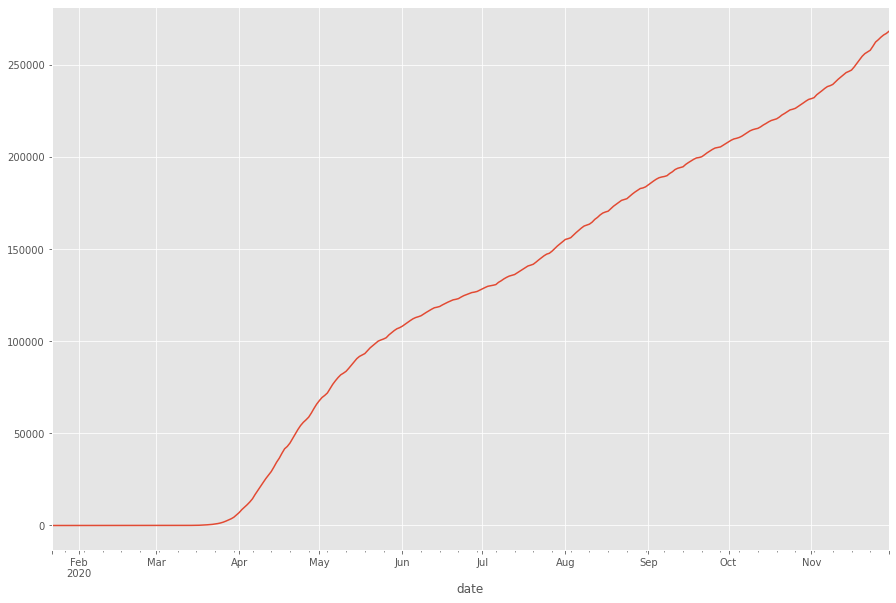

In [8]:
dfB.death_cnt.plot()

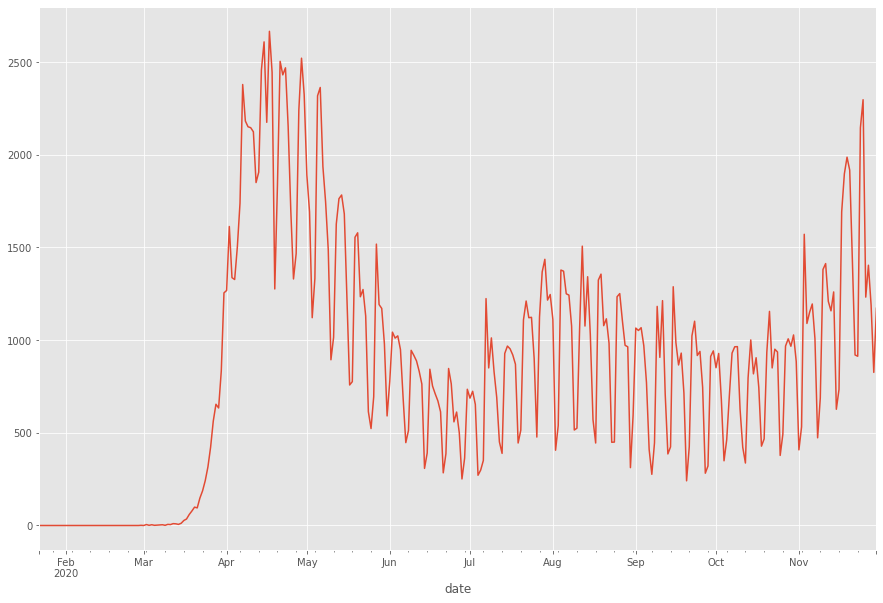

In [9]:
dfB.death_daily.plot()

### Transformation - Log

To stabilize the variance of a time series. 


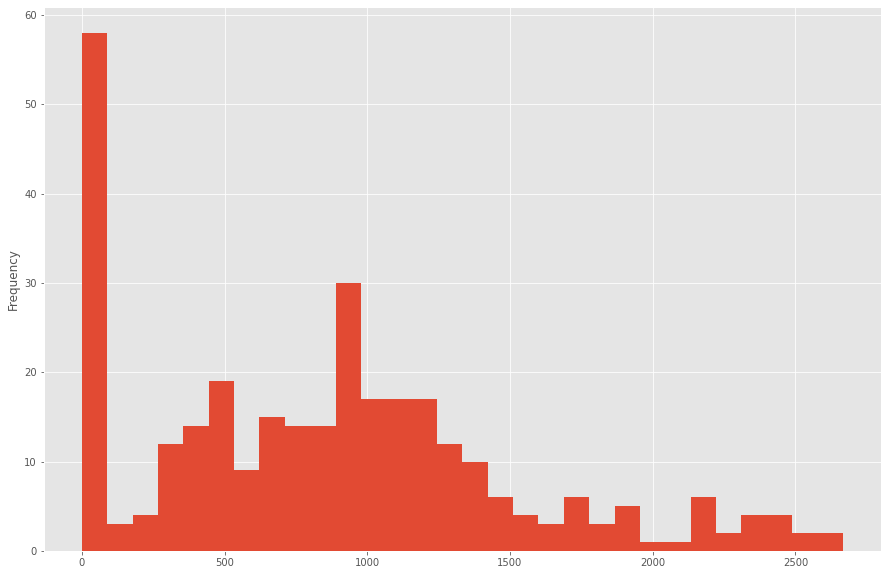

In [11]:
dfB.death_daily.plot(kind = "hist", bins = 30)

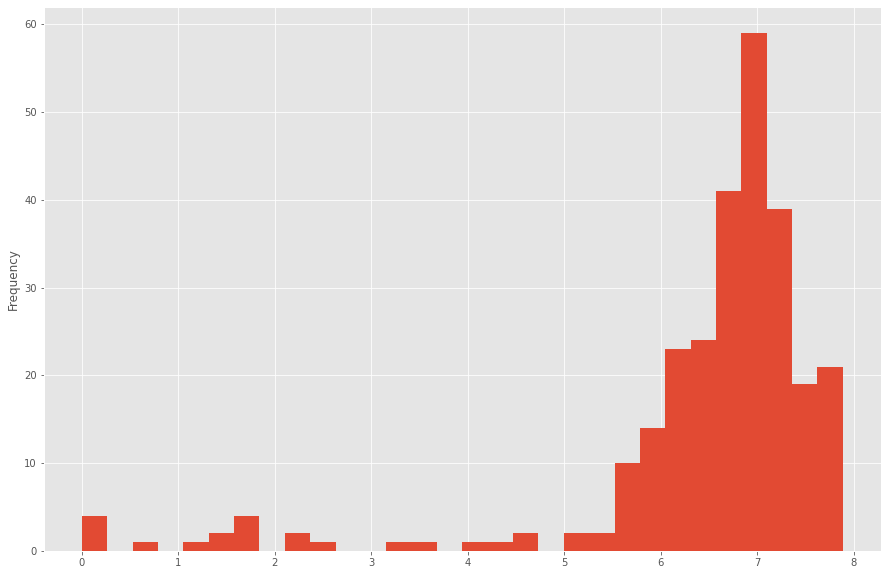

In [13]:
idx = dfB.index[dfB['death_daily'] > 0].tolist()
dfB = dfB.loc[idx]
dfB['death_daily_Log'] = np.log(dfB.death_daily)
dfB.death_daily_Log.plot(kind = "hist", bins = 30)

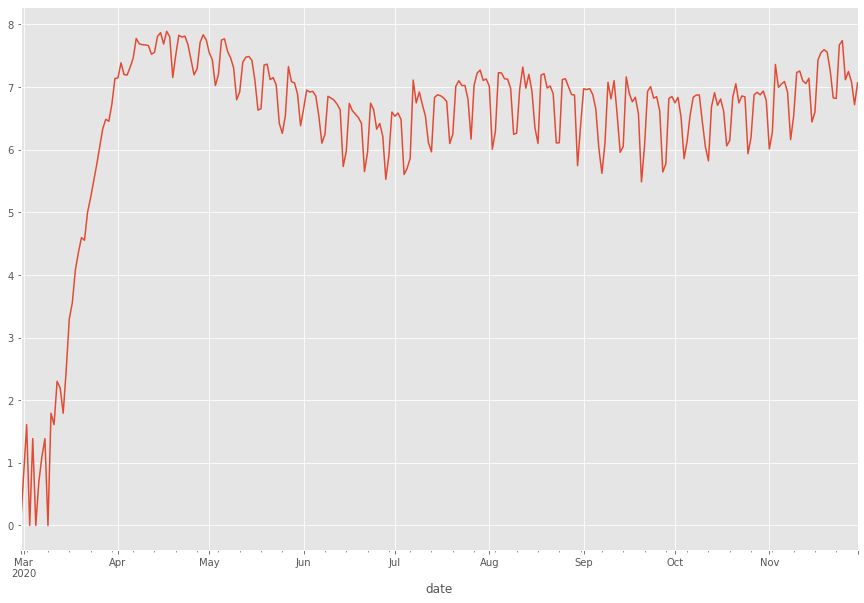

In [14]:
dfB.death_daily_Log.plot()

## Basic Time Series Models

1. Mean Constant Model
2. Linear Trend Model
3. Linear Model with Regressor
4. Random Walk Model


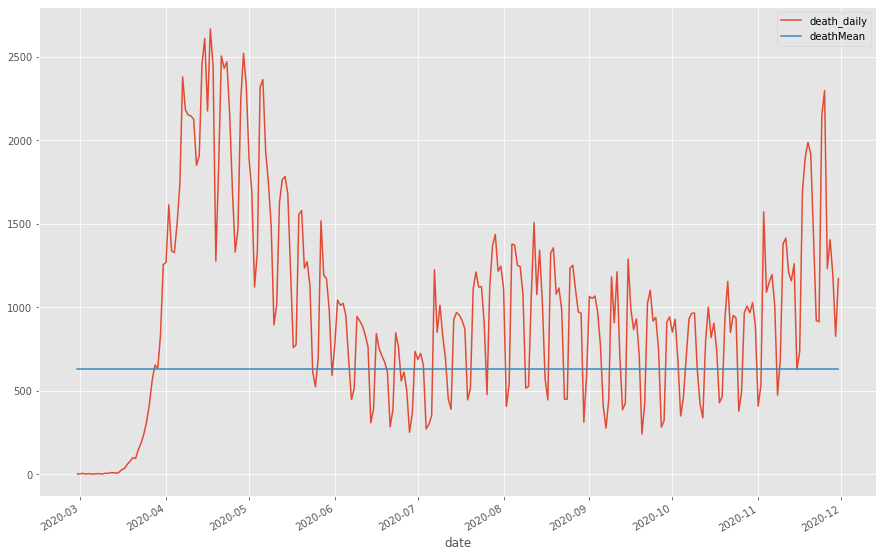

In [15]:
## Mean Model
model_mean_pred = dfB.death_daily_Log.mean()
dfB["deathMean"] = np.exp(model_mean_pred)
dfB.plot(kind="line", x="date", y = ["death_daily", "deathMean"])

In [16]:
## Time Index
dfB["timeIndex"] = dfB.date - dfB.date.min()
dfB["timeIndex"] =  dfB["timeIndex"]/np.timedelta64(1, 'D')
dfB["timeIndex"] = dfB["timeIndex"].round(0).astype(int)
dfB.head()

,date,day_since100,case_cnt,death_cnt,case_daily,death_daily,death_daily_Log,deathMean,timeIndex
date,,,,,,,,,
2020-02-29,2020-02-29,-4,24,1,8,1,0.000000,631.829089,0
2020-03-02,2020-03-02,-2,53,6,23,5,1.609438,631.829089,2
2020-03-03,2020-03-03,-1,73,7,20,1,0.000000,631.829089,3
2020-03-04,2020-03-04,0,104,11,31,4,1.386294,631.829089,4
2020-03-05,2020-03-05,1,174,12,70,1,0.000000,631.829089,5


In [17]:
## Linear Trend Model
model_linear = smf.ols('death_daily_Log ~ timeIndex', data = dfB).fit()
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        death_daily_Log   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     38.63
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           1.90e-09
Time:                        21:28:53   Log-Likelihood:                -472.40
No. Observations:                 275   AIC:                             948.8
Df Residuals:                     273   BIC:                             956.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.5670      0.164     34.019      0.000       5.245       5.889
timeIndex      0.0064      0.001      6.216      0.000       0.004       0.008
==============================================================================
Omnibus:                      119.015   Durbin-Watson:                   0.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              451.584
Skew:                          -1.853   Prob(JB):                     8.71e-99
Kurtosis:                       8.068   Cond. No.                         319.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

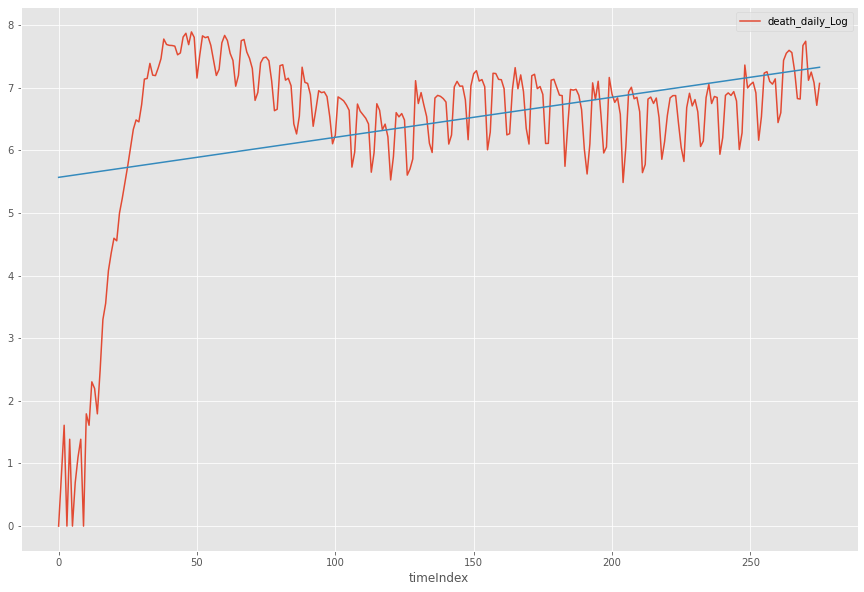

In [18]:
model_linear_pred = model_linear.predict()
dfB.plot(kind="line", x="timeIndex", y = "death_daily_Log")
plt.plot(dfB.timeIndex,model_linear_pred, '-')

In [19]:
dfB["deathLinear"] = np.exp(model_linear_pred)

In [29]:
## Linear Model with Regressor
model_linear_reg = smf.ols('death_daily_Log ~ timeIndex + np.log(case_daily)', data = dfB).fit()
model_linear_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        death_daily_Log   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     779.9
Date:                Fri, 11 Dec 2020   Prob (F-statistic):          2.24e-113
Time:                        21:40:50   Log-Likelihood:                -228.35
No. Observations:                 275   AIC:                             462.7
Df Residuals:                     272   BIC:                             473.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -3.3176      0.253    -13.136      0.000      -3.815      -2.820
timeIndex             -0.0076      0.001    -13.329      0.000      -0.009      -0.006
np.log(case_daily)     1.0518      0.029     36.506      0.000       0.995       1.108
==============================================================================
Omnibus:                        6.867   Durbin-Watson:                   0.664
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                7.007
Skew:                          -0.390   Prob(JB):                       0.0301
Kurtosis:                       2.942   Cond. No.                     1.20e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

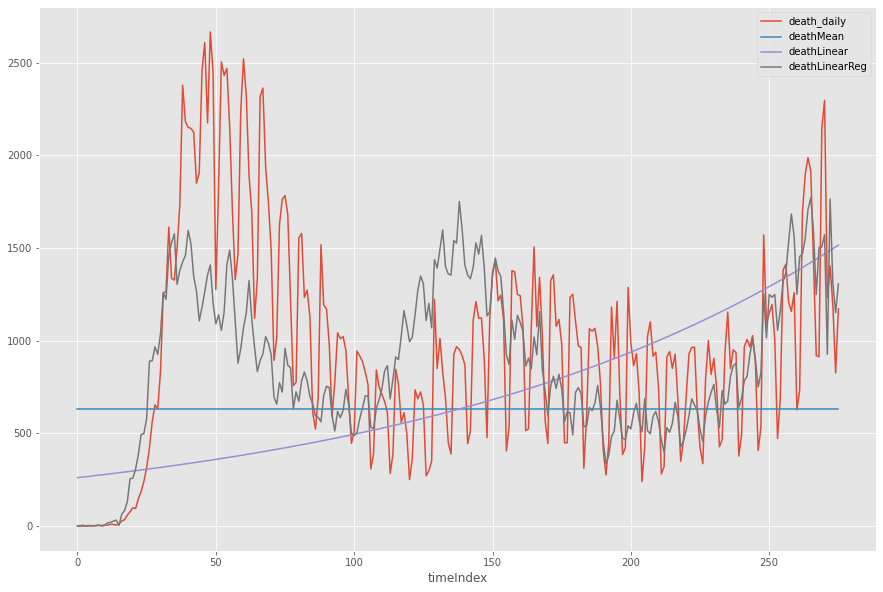

In [30]:
dfB["deathLinearReg"] = np.exp(model_linear_reg.predict())
dfB.plot(kind="line", x="timeIndex", y = ["death_daily", "deathMean", "deathLinear","deathLinearReg"])

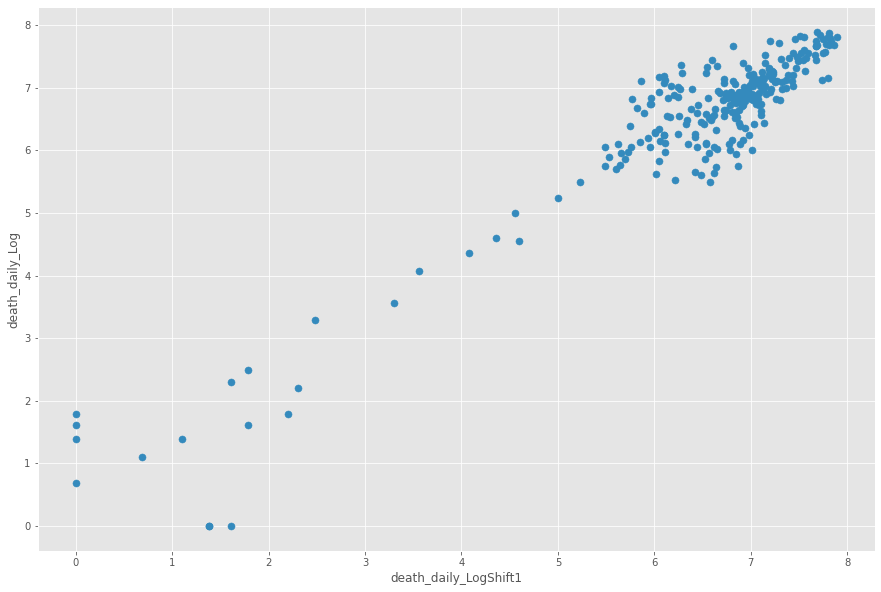

In [24]:
## Random Walk Model - Estimate current day to be same as the previous day
dfB["death_daily_LogShift1"] = dfB.death_daily_Log.shift()
dfB["deathRandom"] = np.exp(dfB.death_daily_LogShift1)
dfB.plot(kind= "scatter", y = "death_daily_Log", x = "death_daily_LogShift1", s = 50)

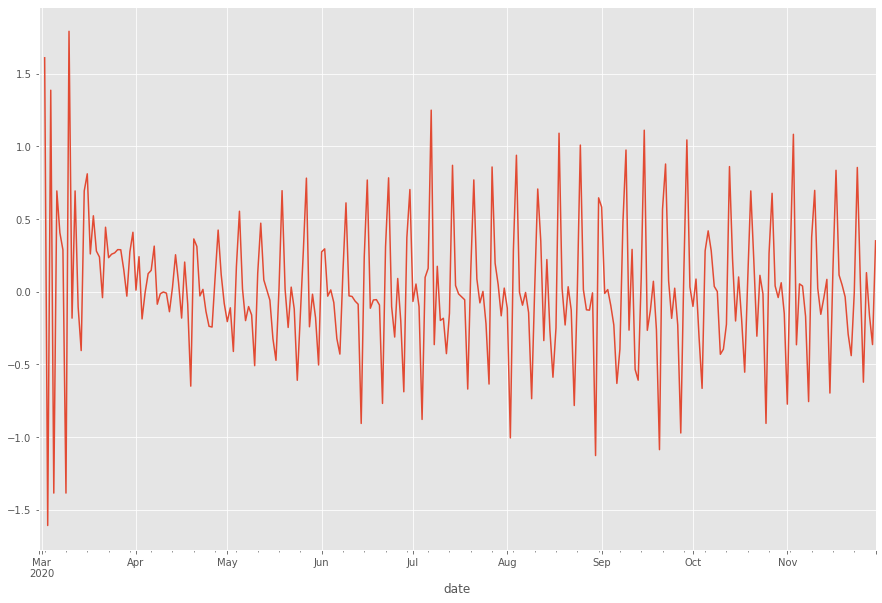

In [23]:
# check log differences for stationarity
dfB["death_daily_LogDiff"] = dfB.death_daily_Log - dfB.death_daily_LogShift1
dfB.death_daily_LogDiff.plot()

##Estimating Trend and Seasonality

###Differencing

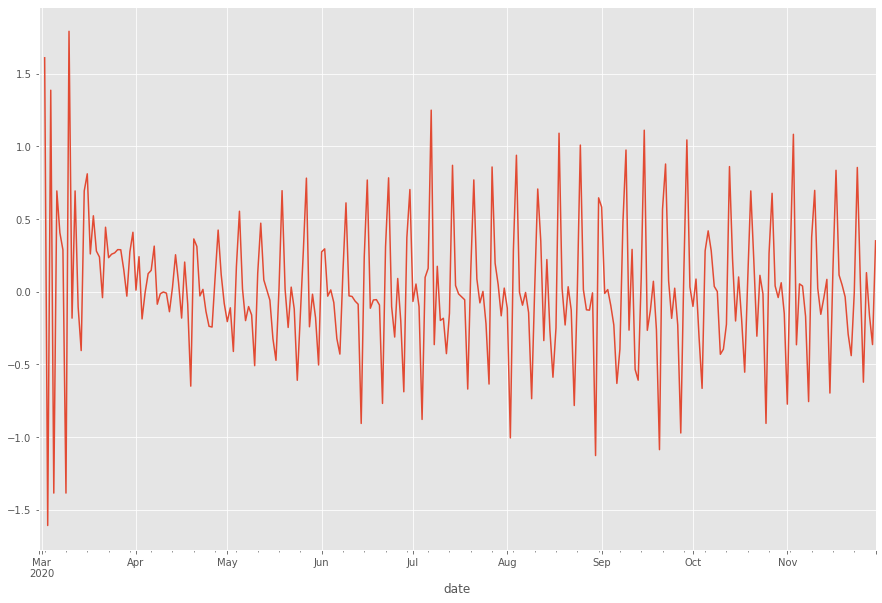

In [35]:
dfB.death_daily_LogDiff.plot()

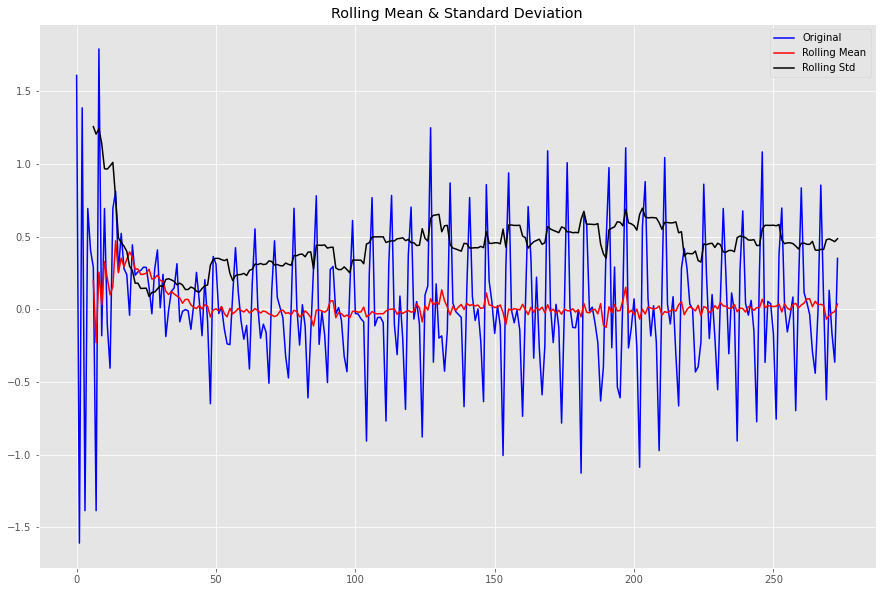

Test Statistic                  -3.082110
p-value                          0.027906
# of Lags Used                  14.000000
Number of Observations Used    259.000000
Critical Value (1%)             -3.455853
Critical Value (5%)             -2.872765
Critical Value (10%)            -2.572752
dtype: float64

In [36]:
## stationarity check
ts = dfB.death_daily_LogDiff
ts.dropna(inplace = True)
adf(ts)

###Decomposition

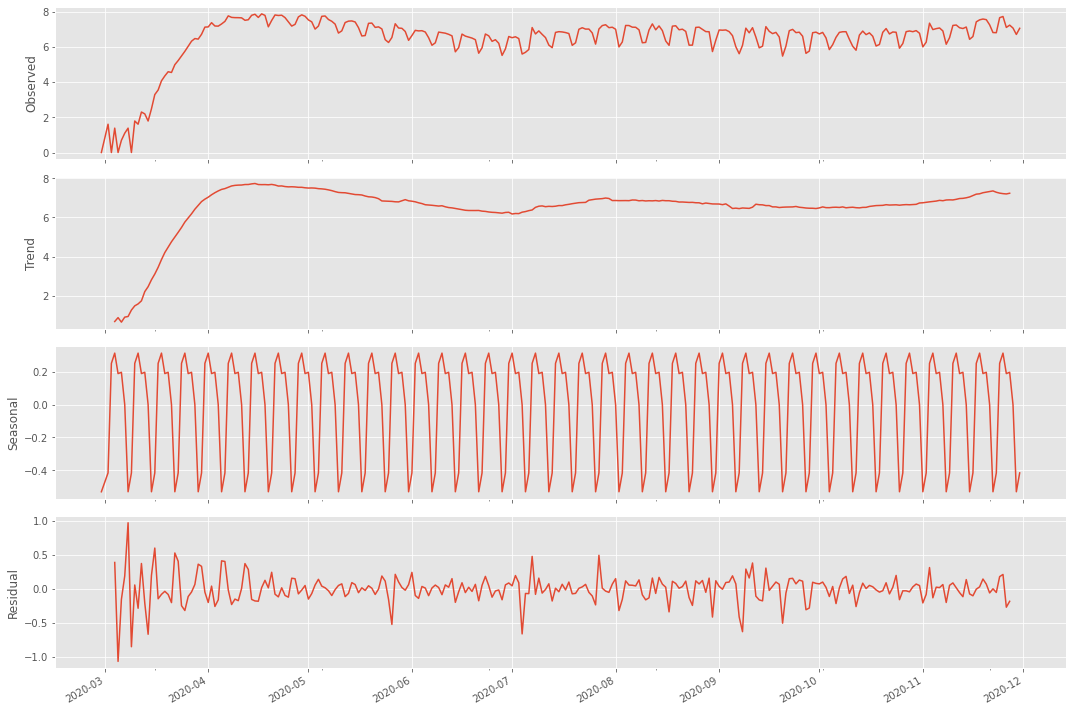

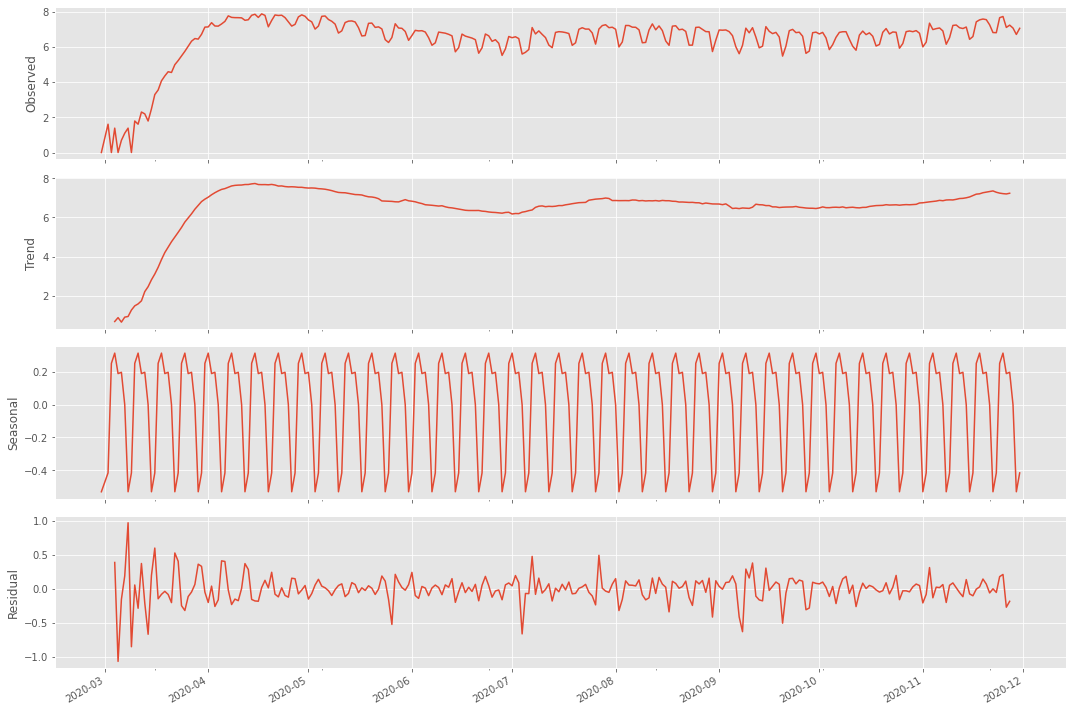

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

dfB.index = pd.DatetimeIndex(dfB.date.values)
df.index = pd.PeriodIndex(df.date, freq='D')
decomposition = seasonal_decompose(dfB.death_daily_Log, freq=7, model = "additive")
decomposition.plot()

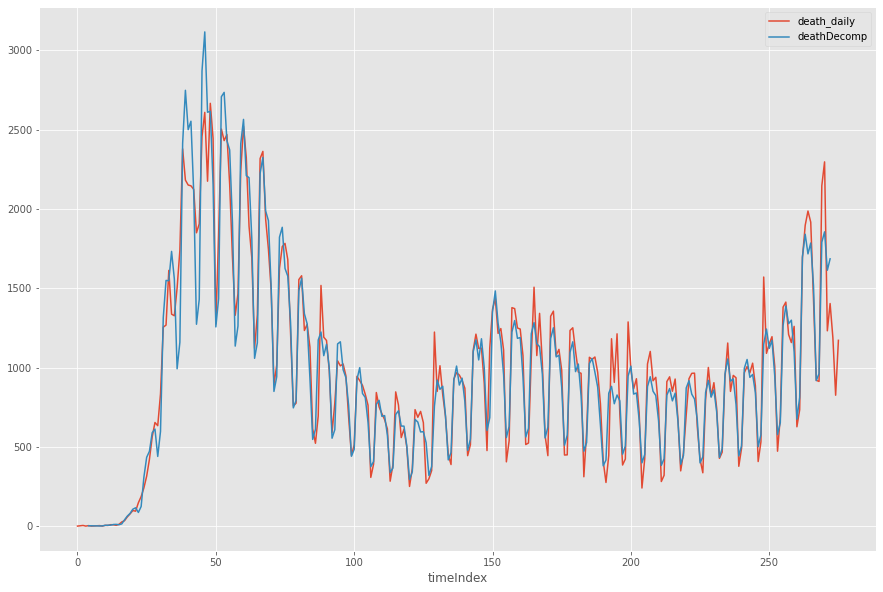

In [41]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

dfB["deathDecomp"] = np.exp(trend + seasonal)
dfB.plot(kind="line", x="timeIndex", y = ["death_daily", "deathDecomp"])


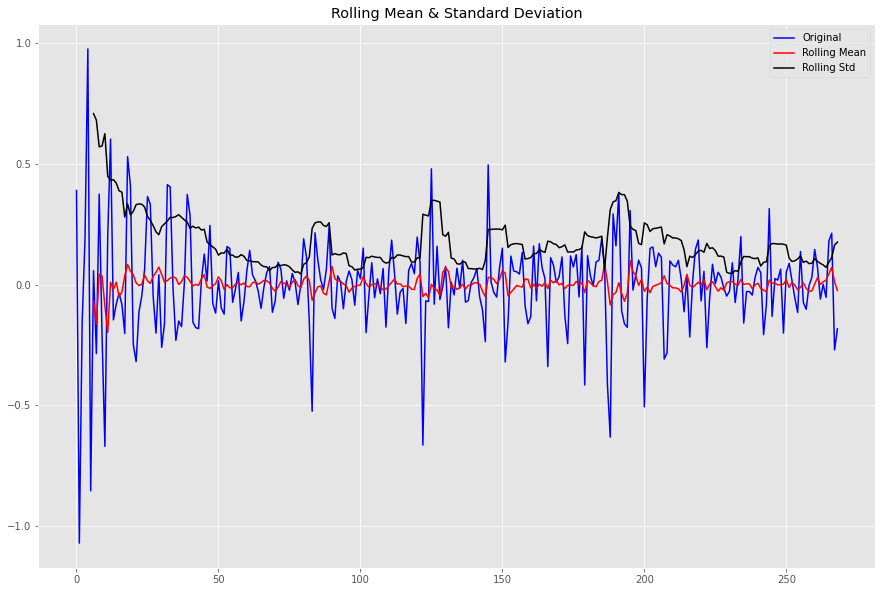

Test Statistic                -1.019172e+01
p-value                        6.296702e-18
# of Lags Used                 7.000000e+00
Number of Observations Used    2.610000e+02
Critical Value (1%)           -3.455656e+00
Critical Value (5%)           -2.872678e+00
Critical Value (10%)          -2.572705e+00
dtype: float64

In [42]:
# Test remaining part for Stationary
ts = decomposition.resid
ts.dropna(inplace = True)
adf(ts)

## Advanced Time Series Models

1. Simple Moving Average (SMA) Model
2. Simple Exponential Smoothing (SES) Model
3. Auto-Regressive Integrated Moving Average (ARIMA) Model


In [25]:
## Augmented Dickey Fuller Test of Stationarity
def adf(ts):
    
    # Determing rolling statistics
    # rolmean = pd.rolling_mean(ts, window=12)
    # rolstd = pd.rolling_std(ts, window=12)

    rolmean = ts.rolling(window=7).mean()
    rolstd = ts.rolling(window=7).std()

    #Plot rolling statistics:
    orig = plt.plot(ts.values, color='blue',label='Original')
    mean = plt.plot(rolmean.values, color='red', label='Rolling Mean')
    std = plt.plot(rolstd.values, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Calculate ADF factors
    adftest = adfuller(ts, autolag='AIC')
    adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','# of Lags Used',
                                              'Number of Observations Used'])
    for key,value in adftest[4].items():
        adfoutput['Critical Value (%s)'%key] = value
    return adfoutput

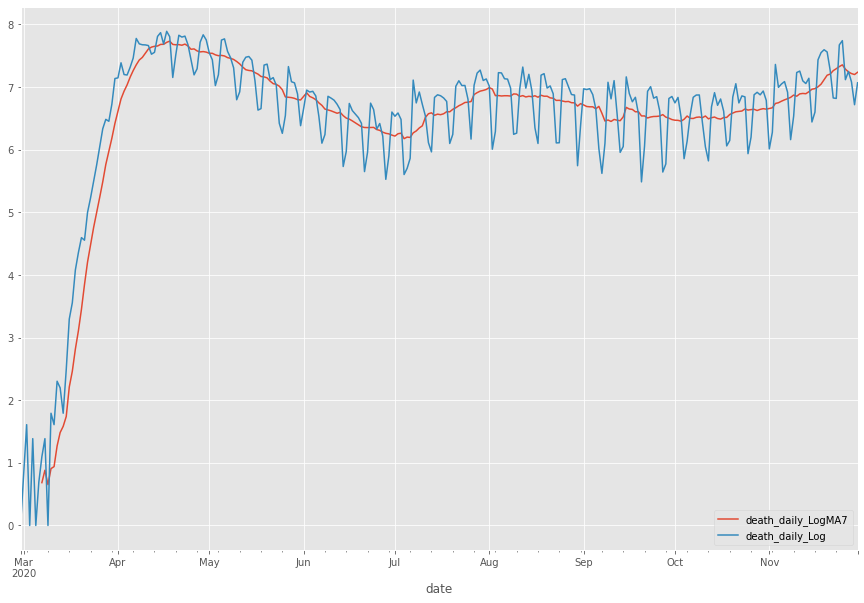

In [31]:
## Simple Moving Average
dfB['death_daily_LogMA7'] = dfB['death_daily_Log'].rolling(window=7).mean()
dfB.plot(kind ="line", y=["death_daily_LogMA7", "death_daily_Log"])
dfB["deathMA7"] = np.exp(dfB.death_daily_LogMA7)

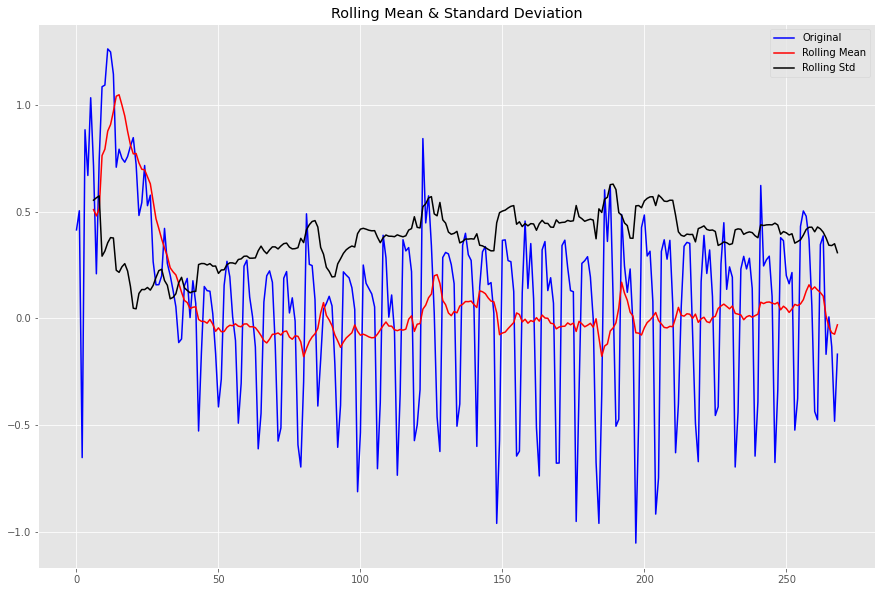

Test Statistic                -6.258096e+00
p-value                        4.289422e-08
# of Lags Used                 1.500000e+01
Number of Observations Used    2.530000e+02
Critical Value (1%)           -3.456464e+00
Critical Value (5%)           -2.873033e+00
Critical Value (10%)          -2.572895e+00
dtype: float64

In [32]:
## Stationarity check
ts = dfB.death_daily_Log - dfB.death_daily_LogMA7
ts.dropna(inplace = True)
adf(ts)

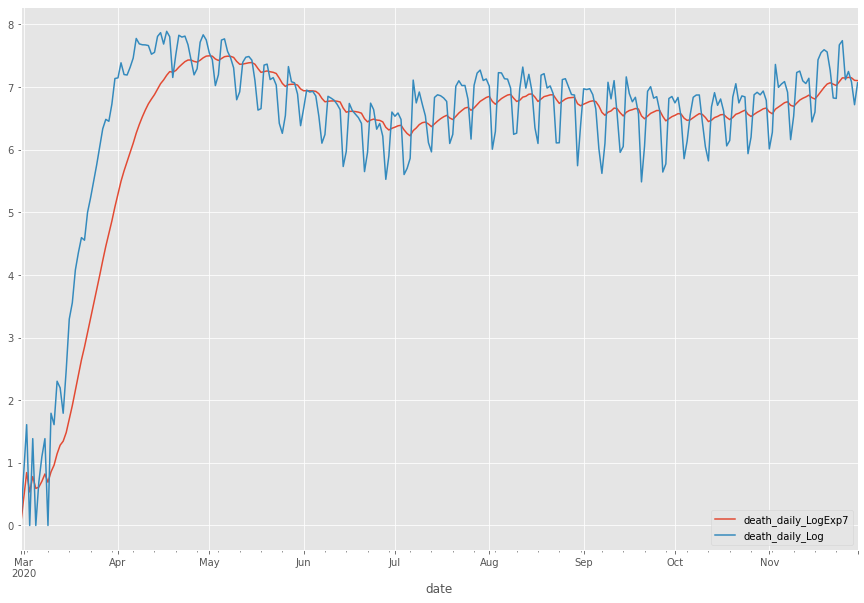

In [33]:
## Simple Exponential Smoothing
dfB['death_daily_LogExp7'] = dfB.death_daily_Log.ewm(halflife=7).mean()
halflife = 7
alpha = 1 - np.exp(np.log(0.5)/halflife)
dfB.plot(kind ="line", y=["death_daily_LogExp7", "death_daily_Log"])
dfB["deathExp7"] = np.exp(dfB.death_daily_LogExp7)

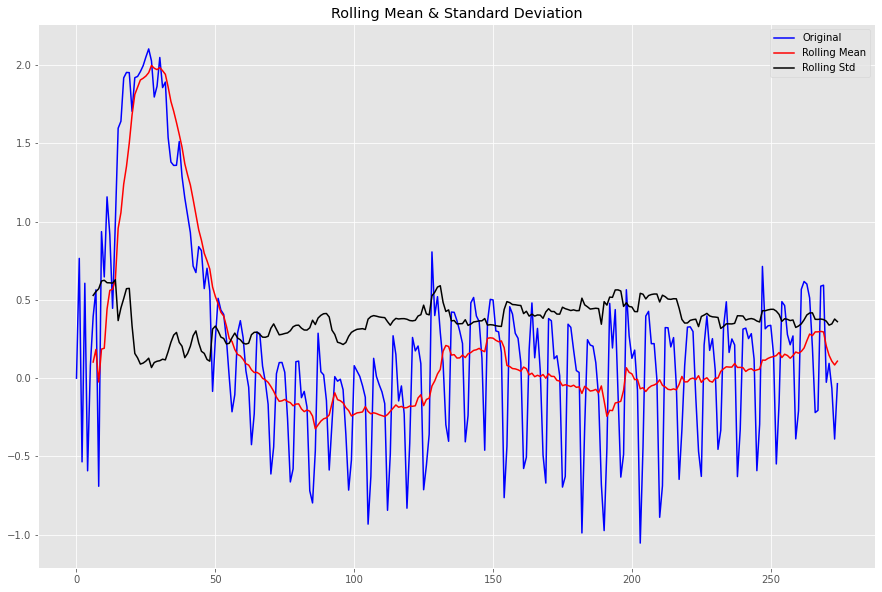

Test Statistic                  -3.914603
p-value                          0.001930
# of Lags Used                  15.000000
Number of Observations Used    259.000000
Critical Value (1%)             -3.455853
Critical Value (5%)             -2.872765
Critical Value (10%)            -2.572752
dtype: float64

In [34]:
ts = dfB.death_daily_Log - dfB.death_daily_LogExp7
ts.dropna(inplace = True)
adf(ts)

In [43]:
ts = dfB.death_daily_Log
ts_diff = dfB.death_daily_LogDiff
ts_diff.dropna(inplace = True)

In [44]:
from statsmodels.tsa.stattools import acf, pacf

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


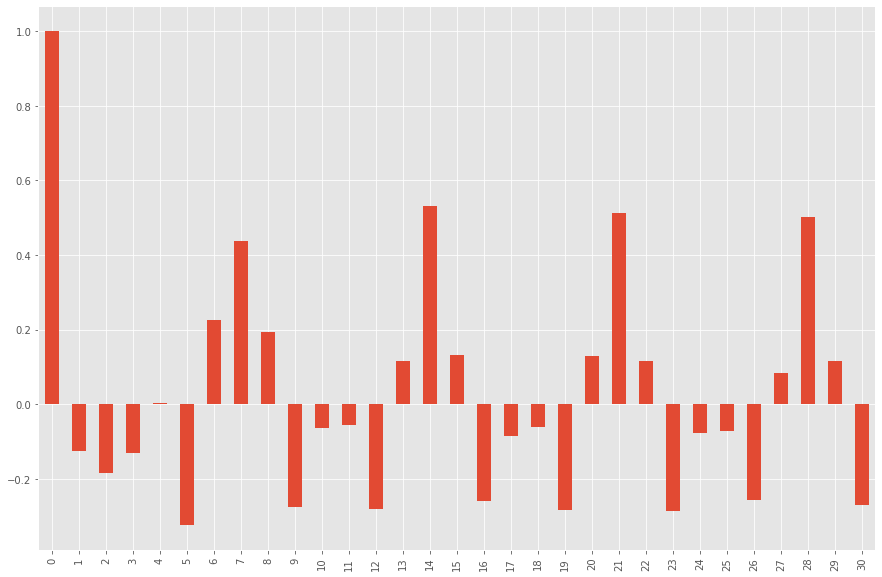

In [46]:
lag_acf = acf(ts_diff, nlags=30)
ACF = pd.Series(lag_acf)
ACF.plot(kind = "bar")

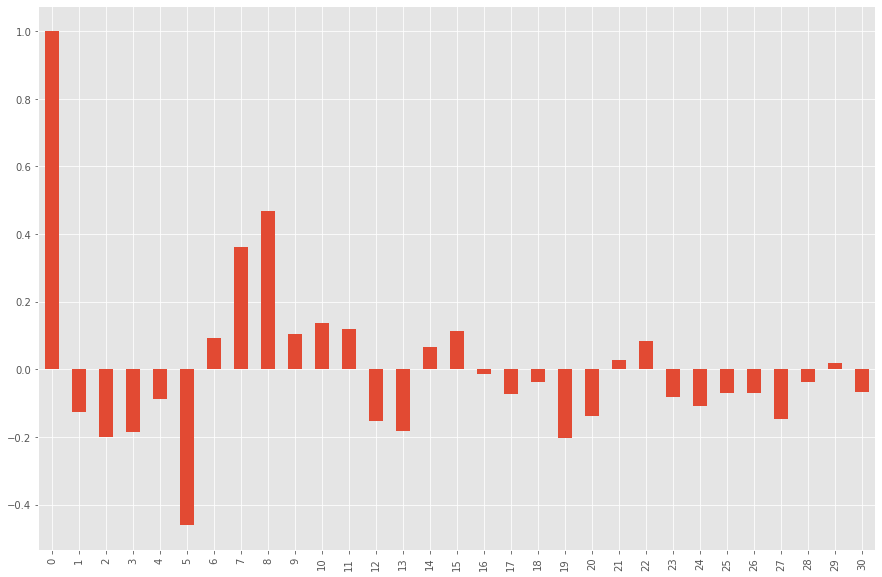

In [47]:
lag_pacf = pacf(ts_diff, nlags=30, method='ols')
PACF = pd.Series(lag_pacf)
PACF.plot(kind = "bar")

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


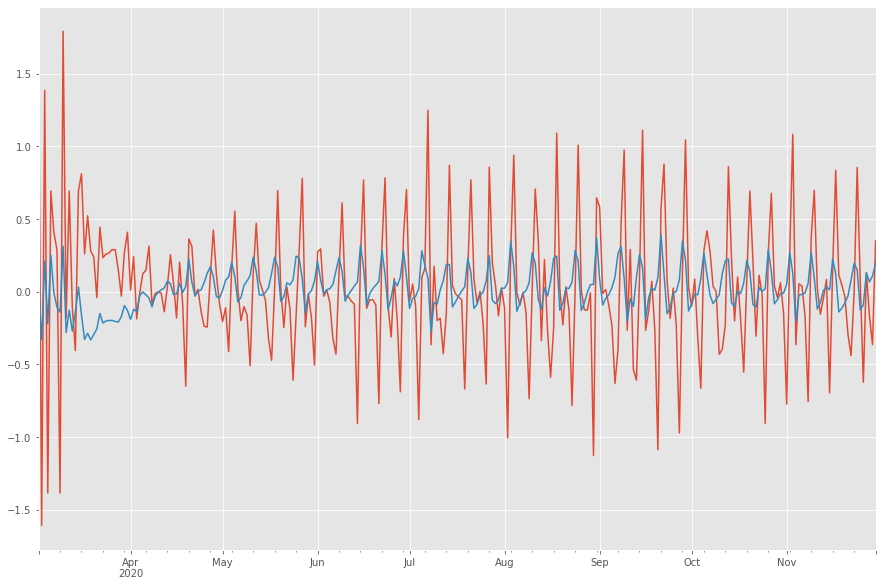

In [48]:
## ARIMA Model
from statsmodels.tsa.arima_model import ARIMA
model_AR1MA = ARIMA(ts_diff, order=(1,0,1))
results_ARIMA = model_AR1MA.fit(disp = -1)
ts_diff.plot()
results_ARIMA.fittedvalues.plot()

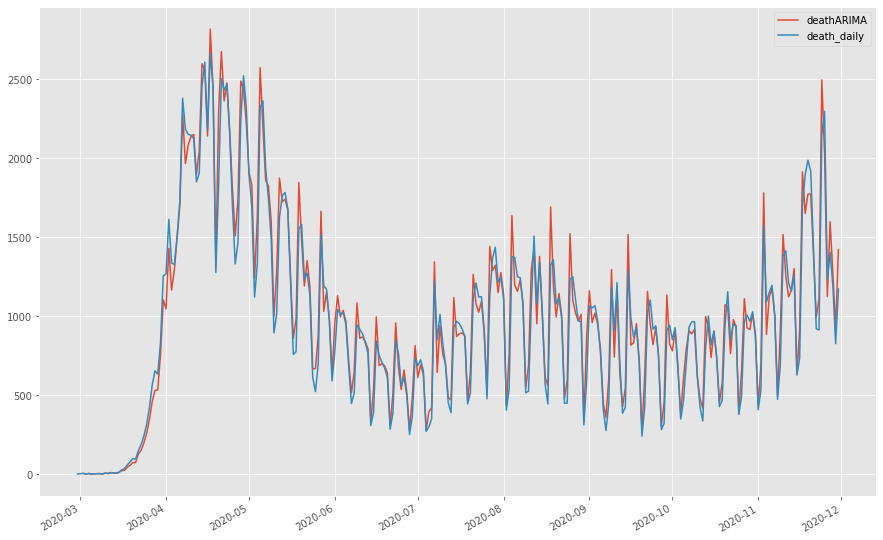

In [52]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts.iloc[0], index=ts.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
dfB['deathARIMA'] = np.exp(ts+predictions_ARIMA_diff)
# plt.plot(ts+predictions_ARIMA_diff)
dfB.plot(kind ="line", y=["deathARIMA", "death_daily"])

##Results

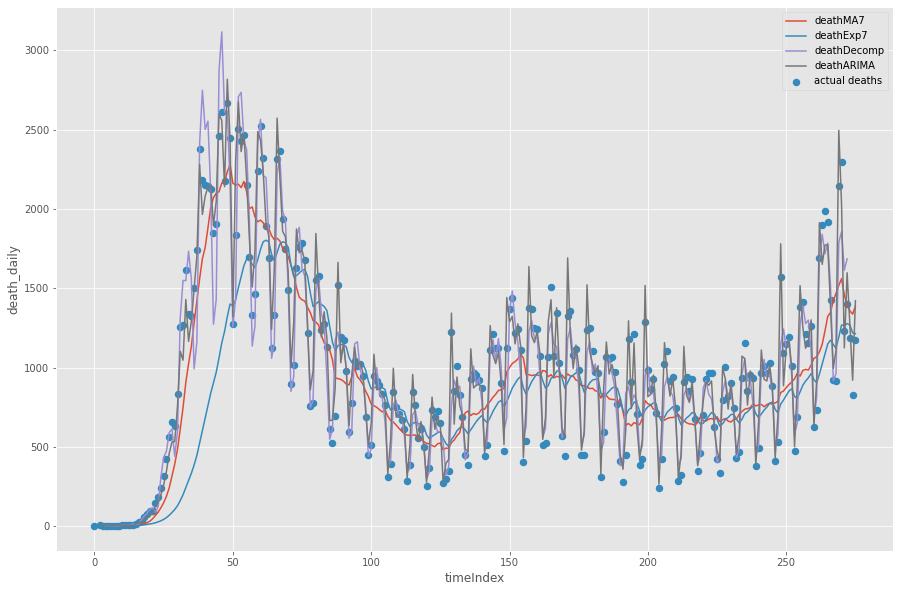

In [53]:
fig, ax = plt.subplots()


# dfB.plot(kind="line", x="timeIndex", y = ["deathMean", "deathLinear", "deathRandom", "deathMA7", "deathExp7", "deathDecomp", "deathARIMA"], ax=ax)
ax = dfB.plot(kind="line", x="timeIndex", y = ["deathMA7", "deathExp7", "deathDecomp", "deathARIMA"], ax=ax)

ax = dfB.plot(kind="scatter", x="timeIndex", y = "death_daily", lw=3, style='b-', ax=ax, label="actual deaths")

Text(0, 0.5, 'Total Death Count')

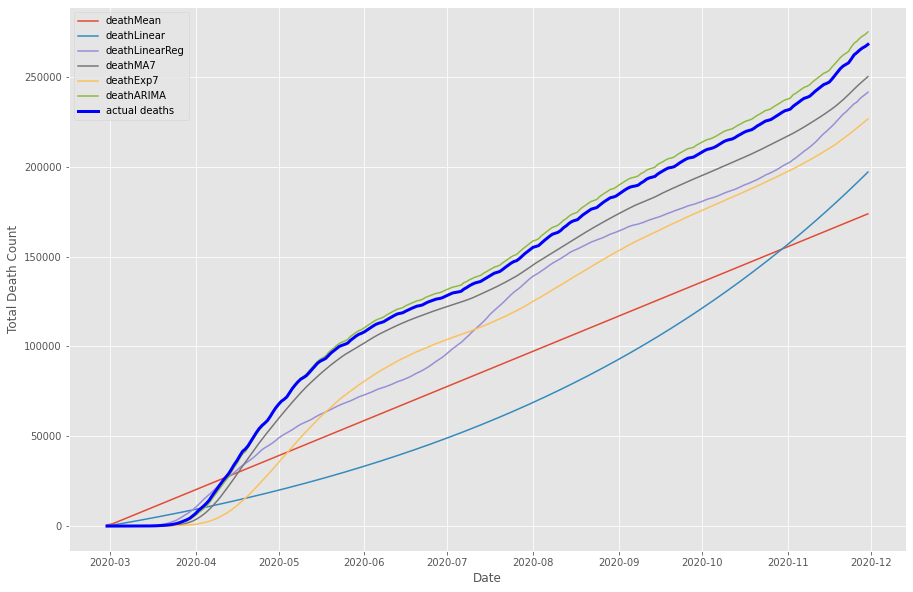

In [54]:
fig, ax = plt.subplots()


# dfB.plot(kind="line", x="timeIndex", y = ["deathMean", "deathLinear", "deathRandom", "deathMA7", "deathExp7", "deathDecomp", "deathARIMA"], ax=ax)
plt.plot(dfB.index, dfB["deathMean"].cumsum(), label="deathMean")
plt.plot(dfB.index, dfB["deathLinear"].cumsum(), label="deathLinear")
plt.plot(dfB.index, dfB["deathLinearReg"].cumsum(), label="deathLinearReg")
plt.plot(dfB.index, dfB["deathMA7"].cumsum(), label="deathMA7")
plt.plot(dfB.index, dfB["deathExp7"].cumsum(), label="deathExp7")
plt.plot(dfB.index, dfB["deathARIMA"].cumsum(), label="deathARIMA")
plt.plot(dfB.index, dfB['death_daily'].cumsum(), linewidth=3, color='blue', label="actual deaths")
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Death Count')

In [55]:
import math
def RMSE(predicted, actual):
    P = []
    A = []
    for i in range(len(predicted)):
      if math.isnan(predicted[i]) or math.isnan(actual[i]):
        continue
      P.append(predicted[i])
      A.append(actual[i])
    mse = (np.array(P) - np.array(A))**2
    rmse = np.sqrt(np.sum(mse)/len(mse))
    return rmse

In [57]:
dfBResults = pd.DataFrame(columns = ["Model", "RMSE"])
model_mean_RMSE = RMSE(dfB.deathMean, dfB.death_daily)
dfBResults.loc[0,"Model"] = "Mean"
dfBResults.loc[0,"RMSE"] = model_mean_RMSE

model_linear_RMSE = RMSE(dfB.deathLinear, dfB.death_daily)
dfBResults.loc[1,"Model"] = "Linear"
dfBResults.loc[1,"RMSE"] = model_linear_RMSE

model_linear_reg_RMSE = RMSE(dfB.deathLinearReg, dfB.death_daily)
dfBResults.loc[2,"Model"] = "Linear Regressor"
dfBResults.loc[2,"RMSE"] = model_linear_reg_RMSE

model_random_RMSE = RMSE(dfB.deathRandom, dfB.death_daily)
dfBResults.loc[3,"Model"] = "Random"
dfBResults.loc[3,"RMSE"] = model_random_RMSE

model_MA7_RMSE = RMSE(dfB.deathMA7, dfB.death_daily)
dfBResults.loc[4,"Model"] = "Moving Average 7"
dfBResults.loc[4,"RMSE"] = model_MA7_RMSE

model_Exp7_RMSE = RMSE(dfB.deathExp7, dfB.death_daily)
dfBResults.loc[5,"Model"] = "Exp Smoothing 7"
dfBResults.loc[5,"RMSE"] = model_Exp7_RMSE

model_ARIMA_RMSE = RMSE(dfB.deathARIMA, dfB.death_daily)
dfBResults.loc[6,"Model"] = "ARIMA"
dfBResults.loc[6,"RMSE"] = model_ARIMA_RMSE

dfBResults

,Model,RMSE
0,Mean,690.773
1,Linear,744.536
2,Linear Regressor,487.28
3,Random,343.971
4,Moving Average 7,327.736
5,Exp Smoothing 7,468.397
6,ARIMA,120.919
